## Notebook for Shin 2022 (Drosophila) anndata file creation 
### Developed by: Anna Maguza

### Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich

### 2nd April 2023

#### Load packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import h5py
from scipy.io import mmread
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import scipy as sci

#### Setup Cells

In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.3.5 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


## Data Upload

In [4]:
# Upload barcodes and features (txt files)
barcodes = pd.read_csv('/Users/anna.maguza/Desktop/Data/Gut_project/Interspecies_analysis/Drosophila/Shin_2022/SCP1696/expression/61b79702771a5b0dd6116d26/WT_barcodes.tsv', sep='\t', header=None)
features = pd.read_csv('/Users/anna.maguza/Desktop/Data/Gut_project/Interspecies_analysis/Drosophila/Shin_2022/SCP1696/expression/61b79702771a5b0dd6116d26/WT_features.tsv', sep='\t', header=None)


In [5]:
# Upload matrix (mtx file)
matrix = mmread('/Users/anna.maguza/Desktop/Data/Gut_project/Interspecies_analysis/Drosophila/Shin_2022/SCP1696/expression/61b79702771a5b0dd6116d26/WT_matrix.mtx')

In [6]:
# Convert matrix to sparse matrix
matrix = sci.sparse.csr_matrix(matrix)

In [7]:
# Upload metadata (csv file)
metadata = pd.read_csv('/Users/anna.maguza/Desktop/Data/Gut_project/Interspecies_analysis/Drosophila/Shin_2022/SCP1696/metadata/WT_metadata.csv')

### Make anndata object

In [15]:
# Metadata preprocessing
# Make column 'NAME' as index
metadata.set_index('NAME', inplace=True)
# Drop row 'TYPE'
metadata.drop('TYPE', inplace=True)

In [9]:
# Make column '0' as index in barcodes and features
barcodes.set_index(0, inplace=True)
features.set_index(0, inplace=True)

In [ ]:
# Merge barcodes and metadata (by index)
barcodes = barcodes.merge(metadata, left_index=True, right_index=True)

In [10]:
# Create anndata object
adata = an.AnnData(X=np.transpose(matrix), obs=barcodes, var=features)

/var/folders/gb/wwnzrh015q9dns5cmsc3xcjsxglkqz/T/ipykernel_47473/1918965695.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = an.AnnData(X=np.transpose(matrix), obs=barcodes, var=features)


In [16]:
#Make a list of cells that are present in barcodes but absent in metadata
cells = list(set(barcodes.index) - set(metadata.index))
# Drop from anndata object cells that are present in barcodes but absent in metadata
adata = adata[~adata.obs.index.isin(cells)]


In [29]:
# Make sure the index name is a string, or set it to None
adata.obs.index.name = str(adata.obs.index.name) if adata.obs.index.name is not None else None

In [30]:
#Make andata.obs.index.name as string
adata.obs.index = adata.obs.index.astype(str)

In [31]:
# Merge the metadata with adata.obs
adata.obs = adata.obs.join(metadata)

In [34]:
adata.var

,1,2
0,,
FBgn0267431,Myo81F,Gene Expression
FBgn0085804,CR41571,Gene Expression
FBgn0039987,CR12798,Gene Expression
FBgn0267798,CR46123,Gene Expression
FBgn0267797,CR46122,Gene Expression
...,...,...
FBgn0267595,CR45933,Gene Expression
FBgn0259864,Su(Ste):CR42433,Gene Expression
FBgn0085506,CG40635,Gene Expression


In [41]:
# Upload UMAP coordinates (txt file)
umap = pd.read_csv('/Users/anna.maguza/Desktop/Data/Gut_project/Interspecies_analysis/Drosophila/Shin_2022/SCP1696/cluster/WT_umap.txt', sep='\t', header=None)

In [42]:
# Make column '0' as index in umap
umap.set_index(0, inplace=True)
# Drop row 'TYPE'
umap.drop('TYPE', inplace=True)
# Make row 'NAME' as columns names in umap
umap.columns = umap.loc['NAME']
# Drop row 'NAME'
umap.drop('NAME', inplace=True)


In [43]:
# Add UMAP coordinates to adata.obsm
adata.obsm['X_umap'] = umap.values


In [44]:
adata

AnnData object with n_obs × n_vars = 3806 × 17737
    obs: 'biosample_id', 'donor_id', 'CellType', 'species', 'species__ontology_label', 'sex', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label'
    var: 1, 2
    obsm: 'X_umap'

In [56]:
adata.var.index.name = "FlyBase_ID"
#Rename adata.var column 1 to gene_name
adata.var.rename(columns={1: "gene_name"}, inplace=True)
#Rename adata.var column 2 to gene_type
adata.var.rename(columns={2: "gene_type"}, inplace=True)

In [57]:
adata.var

,gene_name,gene_type
FlyBase_ID,,
FBgn0267431,Myo81F,Gene Expression
FBgn0085804,CR41571,Gene Expression
FBgn0039987,CR12798,Gene Expression
FBgn0267798,CR46123,Gene Expression
FBgn0267797,CR46122,Gene Expression
...,...,...
FBgn0267595,CR45933,Gene Expression
FBgn0259864,Su(Ste):CR42433,Gene Expression
FBgn0085506,CG40635,Gene Expression


In [58]:
adata.obs.index = adata.obs.index.astype(str)
adata.var.index = adata.var.index.astype(str)
adata.obs_names = adata.obs_names.astype(str)
adata.var.index.name = str(adata.var.index.name) if adata.var.index.name is not None else None
adata.var_names = adata.var_names.astype(str)
adata.obs = adata.obs.astype(str)
adata.var = adata.var.astype(str)

In [59]:
# Save anndata object
adata.write('/Users/anna.maguza/Desktop/Data/Gut_project/Interspecies_analysis/Drosophila/Shin_2022/Raw_anndata_file/Shin_2022_raw_anndata.h5ad')

In [60]:
adata.obs

,biosample_id,donor_id,CellType,species,species__ontology_label,sex,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label
0,,,,,,,,,,,,
AAACCCAAGAGTCCGA-1,WT,WT,"esg-,N+",NCBITaxon:7227,Drosophila melanogaster,female,PATO_0000461,normal,UBERON_0000160,intestine,EFO:0009922,10x 3' v3
AAACCCAAGTGGACGT-1,WT,WT,aEC,NCBITaxon:7227,Drosophila melanogaster,female,PATO_0000461,normal,UBERON:0000160,intestine,EFO:0009922,10x 3' v3
AAACCCACAAGTGACG-1,WT,WT,mEC-1,NCBITaxon:7227,Drosophila melanogaster,female,PATO_0000461,normal,UBERON:0000160,intestine,EFO:0009922,10x 3' v3
AAACCCAGTTTGGAGG-1,WT,WT,pEC-2,NCBITaxon:7227,Drosophila melanogaster,female,PATO_0000461,normal,UBERON:0000160,intestine,EFO:0009922,10x 3' v3
AAACCCATCTAAACGC-1,WT,WT,Progenitors,NCBITaxon:7227,Drosophila melanogaster,female,PATO_0000461,normal,UBERON:0000160,intestine,EFO:0009922,10x 3' v3
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGAGAGACTCCGC-1,WT,WT,mEC-2,NCBITaxon:7227,Drosophila melanogaster,female,PATO_0000461,normal,UBERON:0000160,intestine,EFO:0009922,10x 3' v3
TTTGGTTAGCCTTTCC-1,WT,WT,Immature EC,NCBITaxon:7227,Drosophila melanogaster,female,PATO_0000461,normal,UBERON:0000160,intestine,EFO:0009922,10x 3' v3
TTTGTTGAGCGTATAA-1,WT,WT,Unknown-2,NCBITaxon:7227,Drosophila melanogaster,female,PATO_0000461,normal,UBERON:0000160,intestine,EFO:0009922,10x 3' v3


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Immature EC'),
  Text(1, 0, 'Progenitors'),
  Text(2, 0, 'aEC'),
  Text(3, 0, 'pEC-1'),
  Text(4, 0, 'mEC-1'),
  Text(5, 0, 'mEC-2'),
  Text(6, 0, 'EC'),
  Text(7, 0, 'pEC-2'),
  Text(8, 0, 'EE'),
  Text(9, 0, 'esg-,N+'),
  Text(10, 0, 'Unknown-1'),
  Text(11, 0, 'Unknown-2'),
  Text(12, 0, 'Unknown-3'),
  Text(13, 0, 'CC'),
  Text(14, 0, 'cardia'),
  Text(15, 0, 'LFC')])

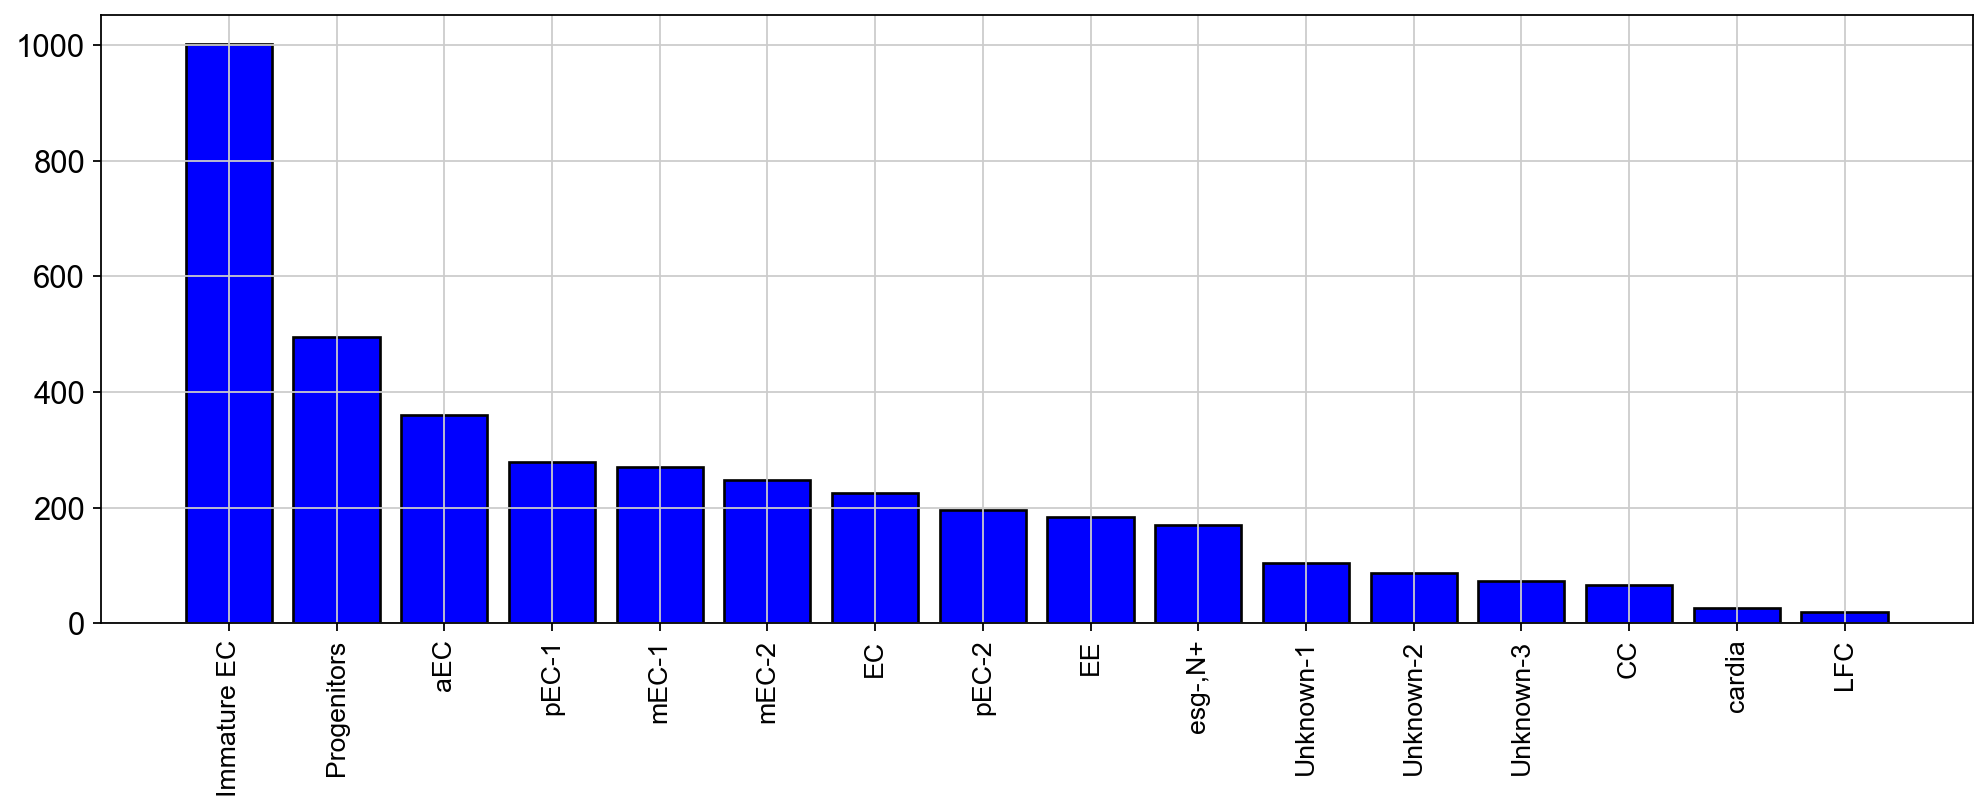

In [61]:
# Make a plot with cell types 
#Create a barplot of the number of cells per cell type in the anndata_pediatric object
plt.figure(figsize = (15, 5))
plt.bar(adata.obs["CellType"].value_counts().index, adata.obs["CellType"].value_counts(), color = "blue", edgecolor = "black", linewidth = 1.2)
plt.xticks(rotation = 90, fontsize = 12)